In [1]:
import cvxpy as cp
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time
from joblib import Parallel, delayed
from os import cpu_count

import src.utils as utils
import src.spectral_nti as snti

SEED = 0
N_CPUS = cpu_count()
PATH = './results/ref_graph_errs/'
np.random.seed(SEED)

In [11]:
def run_exp(id,  model, Iters, NN, g_params, M):
    # Create ref graph
    if g_params['type'] == 'SW':
        A0 = nx.to_numpy_array(nx.watts_strogatz_graph(g_params['N0'], g_params['k'],
                                                       g_params['p'], seed=SEED))
    else:
        b_size0 = [int(g_params['N0']/g_params['K'])]*g_params['K']
        A0 = nx.to_numpy_array(nx.random_partition_graph(b_size0, g_params['p']/g_params['N0'],
                                                         g_params['q']))

    L0 = np.diag(np.sum(A0, 0)) - A0
    lamds0, _ = np.linalg.eigh(L0)

    err = np.zeros((len(NN), len(Iters)))
    ellapsed_t = np.zeros((len(NN), len(Iters)))
    for i, N in enumerate(NN):
        # Create graph
        if g_params['type'] == 'SW':
            A = nx.to_numpy_array(nx.watts_strogatz_graph(N, g_params['k'], g_params['p'],
                                                          seed=SEED))
        else:
            b_size = [int(N/g_params['K'])]*g_params['K']
            A = nx.to_numpy_array(nx.random_partition_graph(b_size, g_params['p']/N, g_params['q']))

        L = np.diag(np.sum(A, 0)) - A
        lamds, _ = np.linalg.eigh(L)
        X = utils.create_signals(L, M)
        C_hat = X@X.T/(M-1)

        model['cs'], cs_err = utils.compute_cs(model['gs'], lamds0, lamds)
                
        for j, iters in enumerate(Iters):
            t = time.time()
            L_hat, _ = snti.MGL(C_hat, model['gs'], model['bounds'], model['cs'],
                            model['regs'], max_iters=iters, epsilon=1e-4)

            ellapsed_t[i,j] = time.time() - t

            # Compute error
            norm_L = np.linalg.norm(L, 'fro')
            norm_L_hat = 1 if np.all(L_hat == 0) else np.linalg.norm(L_hat, 'fro')
            err[i,j] = np.linalg.norm(L/norm_L - L_hat/norm_L_hat, 'fro')**2

            print('Graph-{}, N-{}: iters: {} - cs err: {:.4f} - Time(sec): {:.3} . err: {:.4}'.
                  format(id, N, iters, cs_err[0], ellapsed_t[i,j], err[i,j]))

    return err, ellapsed_t


def plot_result(NN, Iters, err, ylab, logy=True, ylim=[], skip=[]):
    plt.figure()

    for i, iters in enumerate(Iters):
        if i in skip:
            continue
        leg = 'iters=' + str(iters)

        if logy:
            plt.loglog(NN, err[:,i], 'o-', label=leg,
                       linewidth=2, markersize=12)
        else:
            plt.semilogx(NN, err[:,i], 'o-', label=leg,
                         linewidth=2, markersize=12)
                            
    plt.grid(True)
    plt.xlabel('Number of nodes')
    plt.ylabel(ylab)
    plt.legend()
    plt.xlim([NN[0], NN[-1]])
    if ylim:
        plt.ylim(ylim)
    plt.tight_layout()


## Using SW graphs - M=5e4

In [3]:
# Experiment variables
NN = [10, 50, 100, 200, 300, 500, 750, 1000]
Iters = [5, 10, 25, 50]
M = 5000
n_graphs = 30

# Graph parameters
g_params = {'type': 'SW', 'N0': 500, 'p': .1, 'k': 10}

gs = lambda a, b : cp.sum(.25*a**2-.75*a)/b
bounds = lambda lamd, lamd_t, b: 1/b*(0.75-2*0.25*lamd_t).T@lamd

model = {'name': 'MGL-Poly', 'gs': gs, 'bounds': bounds,  # 'fmt': 's--',
         'regs': {'alpha': 0, 'beta': 1.1, 'gamma': 5000, 'deltas': .03}}

In [4]:
total_t = time.time()
err = np.zeros((len(NN), len(Iters), n_graphs))
ellapsed_t = np.zeros((len(NN), len(Iters), n_graphs))

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, model, Iters, NN, g_params, M) for i in range(n_graphs))

for i, resp in enumerate(resps):
   err[:,:,i], ellapsed_t[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 40.11322315533956  mins -----


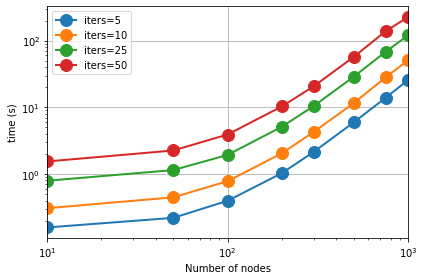

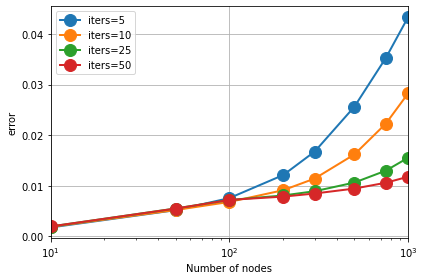

In [8]:
mean_err = np.mean(err, 2)
mean_t = np.mean(ellapsed_t, 2)

plot_result(NN, Iters, mean_t, 'time (s)', logy=True, ylim=[], skip=[])
plot_result(NN, Iters, mean_err, 'error', logy=False, ylim=[], skip=[])

In [7]:
### SAVE
# data = {
#     'NN': NN,
#     'Iters': Iters,
#     'M': M,
#     'err': err,
#     'ellapsed_t': ellapsed_t,
#     'n_graphs': n_graphs,
#     'g_params': g_params,
# }

# file = 'eff_SW_{}graphs_{}-M'.format(n_graphs, M)
# np.save('results/efficiency/' + file, data)

In [3]:
# ### LOAD
# %matplotlib qt

# file = 'results/efficiency/' + 'eff_SW_30graphs_5000-M.npy'
# data = np.load(file, allow_pickle=True).item()
# NN = data['NN']
# Iters = data['Iters']
# M = data['M']
# err = data['err']
# ellapsed_t = data['ellapsed_t']

## Using SBM graphs - M=5e4

In [10]:
# Experiment variables
NN = [25, 50, 100, 200, 300, 500, 750, 1000]
Iters = [5, 10, 25, 50]
M = 5000
n_graphs = 100

# Graph parameters
g_params = {'type': 'SBM', 'N0': 300, 'K': 5, 'p': .3*70, 'q': 0}

gs = lambda a, b : cp.sum(.25*a**2-.75*a)/b
bounds = lambda lamd, lamd_t, b: 1/b*(0.75-2*0.25*lamd_t).T@lamd

model = {'name': 'MGL-Poly', 'gs': gs, 'bounds': bounds,  # 'fmt': 's--',
         'regs': {'alpha': 0, 'beta': .3, 'gamma': 1000, 'deltas': 3}}


In [11]:
total_t = time.time()
err = np.zeros((len(NN), len(Iters), n_graphs))
ellapsed_t = np.zeros((len(NN), len(Iters), n_graphs))

print('N_CPUS:', N_CPUS)
pool = Parallel(n_jobs=N_CPUS, verbose=0)
resps = pool(delayed(run_exp)(i, model, Iters, NN, g_params, M) for i in range(n_graphs))

for i, resp in enumerate(resps):
   err[:,:,i], ellapsed_t[:,:,i] = resp

total_t = time.time() - total_t
print('-----', total_t/60, ' mins -----')

N_CPUS: 12
----- 36.82424773772558  mins -----


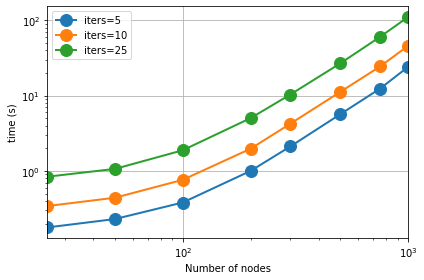

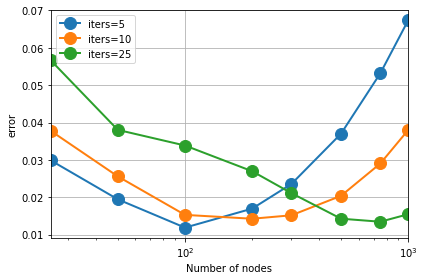

In [10]:
mean_err = np.mean(err, 2)
mean_t = np.mean(ellapsed_t, 2)

plot_result(NN, Iters, mean_t, 'time (s)', logy=True, ylim=[], skip=[3])
plot_result(NN, Iters, mean_err, 'error', logy=False, ylim=[], skip=[3])

In [14]:
# data = {
#     'NN': NN,
#     'Iters': Iters,
#     'M': M,
#     'err': err,
#     'ellapsed_t': ellapsed_t,
#     'n_graphs': n_graphs,
#     'g_params': g_params,
# }

# file = 'eff_SBM_{}graphs_{}-M'.format(n_graphs, M)
# np.save('results/efficiency/' + file, data)

In [9]:
# ### LOAD
# %matplotlib qt

# file = 'results/efficiency/' + 'eff_SBM_30graphs_5000-M.npy'
# data = np.load(file, allow_pickle=True).item()
# NN = data['NN']
# Iters = data['Iters']
# M = data['M']
# err = data['err']
# ellapsed_t = data['ellapsed_t']

